In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as stats

from os import makedirs
from urllib.request import urlretrieve

import pymc3 as pm

In [5]:
makedirs("data", exist_ok=True)
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x11113ce48>)

In [6]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
print("%s days" % n_count_data)

74 days


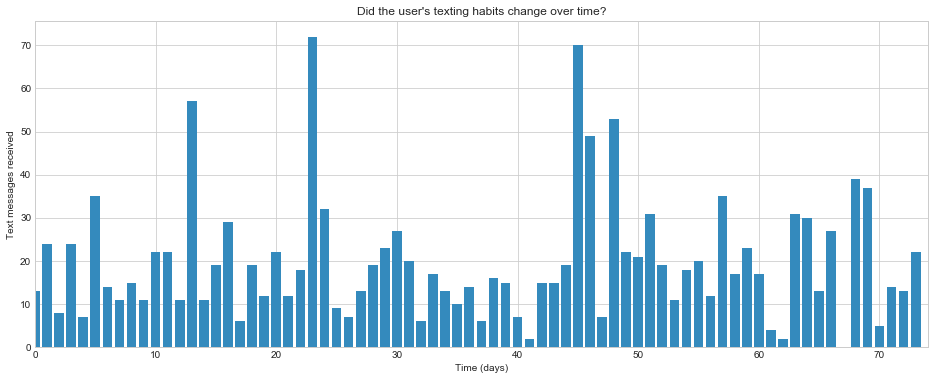

In [7]:
plt.figure(figsize=(16, 6))

plt.bar(np.arange(n_count_data), count_data, color="#348ABD")

plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

# PyMC

In [68]:
with pm.Model() as model:
    alpha = 1.0 / count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

In [69]:
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [70]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [71]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

100%|██████████| 15000/15000 [00:06<00:00, 2325.06it/s]


In [73]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [74]:
len(lambda_1_samples), len(lambda_2_samples), len(tau_samples)

(10000, 10000, 10000)

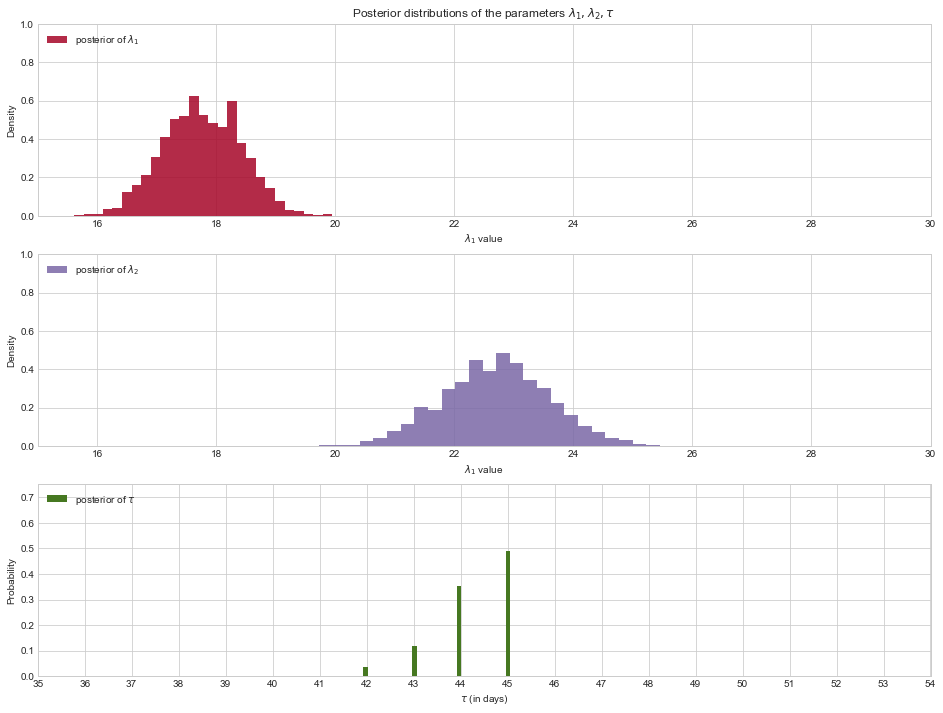

In [75]:
plt.figure(figsize=(16, 12))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#A60628", normed=True, label="posterior of $\lambda_1$")
plt.legend(loc="upper left")
plt.title(r"Posterior distributions of the parameters $\lambda_1, \lambda_2, \tau$")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#7A68A6", normed=True, label="posterior of $\lambda_2$")
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1, label=r"posterior of $\tau$", color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, 0.75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability")

plt.show()